# Saddle-to-Saddle Dynamics in Fully Connected Linear Networks

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [423]:
def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))

    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))

    ax.xaxis.offsetText.set_fontsize(20)
    ax.grid()

    # Remove top/right borders and set linewidth
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

## Empirics

In [725]:
def generate_matrix_with_power_law(c, d, magnitude, exponent):
    min_dim = min(c, d)
    
    # Generate random orthogonal matrices U and V
    U, _ = np.linalg.qr(np.random.randn(c, c))
    V, _ = np.linalg.qr(np.random.randn(d, d))
    
    # Generate power-law singular values
    singular_values = magnitude * np.power(np.arange(1, min_dim + 1), -exponent)
    
    # Construct diagonal matrix with singular values
    S = np.zeros((c, d))
    np.fill_diagonal(S, singular_values)
    
    # Construct the matrix with the desired SVD structure
    A = U[:, :min_dim] @ S[:min_dim, :min_dim] @ V[:min_dim, :]
    
    return A

In [841]:
# Set random seed for reproducibility
np.random.seed(0)

# Define dimensions
c = 10    # Output dimension
H = 10   # Hidden layer dimension
d = 10    # Input dimension

# Generate input covariance matrix
Sigma_xx = np.random.randn(d, d)
Sigma_xx = generate_matrix_with_power_law(d, d, 1, 1.0)
Sigma_xx = Sigma_xx @ Sigma_xx.T  # Unwhitened
# Sigma_xx = 10 * np.eye(d) # Whitened

# Generate ground-truth transformation B
B = np.random.randn(c, d)
# B = generate_matrix_with_power_law(c, d, 1, 1.0)

# # Commuting parameterization
# _, _, V = np.linalg.svd(B)
# _, s, _ = np.linalg.svd(Sigma_xx)
# Sigma_xx = V.T @ np.diag(s) @ V

# Compute output-input cross-covariance
Sigma_yx = B @ Sigma_xx

# Initialization scale (small alpha)
init_scale = 1e-10

# Initialize network parameters
A0 = np.random.randn(c, H) * (init_scale / np.sqrt(c))
W0 = np.random.randn(H, d) * (init_scale / np.sqrt(d))

# # Initialize normalized network parameters
# A = np.random.randn(c, H)
# A *= init_scale / np.linalg.norm(A, axis=0, keepdims=True)
# W = np.random.randn(H, d)
# W *= init_scale / np.linalg.norm(W, axis=1, keepdims=True)

# # # Initialize aligned network parameters
# U, S, VT = np.linalg.svd(Sigma_yx)
# A0 = init_scale *  U
# W0 = init_scale * VT

A, W = A0.copy(), W0.copy()

# Training parameters
num_epochs = int(5e5)
learning_rate = 1e-2
batch_size = int(1e3)

# Track loss / singular values over time
loss_history = []
svalue_history = []

# Online training loop
for epoch in range(num_epochs):
    # Generate a batch of input data
    X_batch = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma_xx, size=batch_size).T
    
    # Compute ground-truth output
    Y_batch = B @ X_batch
    
    # Forward pass
    Y_pred = A @ W @ X_batch
    
    # Compute loss (mean squared error)
    loss = np.mean((Y_pred - Y_batch) ** 2)
    loss_history.append(loss)

    # Add theta
    num = min(d, H, c)
    _, s, _ = np.linalg.svd(A @ W)
    svalue_history.append(s[:num])
    
    # Compute gradients
    dL_dY = 2 * (Y_pred - Y_batch) / batch_size
    dL_dA = dL_dY @ (W @ X_batch).T
    dL_dW = A.T @ dL_dY @ X_batch.T
    
    # Gradient descent updates
    A -= learning_rate * dL_dA
    W -= learning_rate * dL_dW
    
    # Print progress every 100 epochs
    if epoch % (num_epochs // 10) == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

Epoch 0: Loss = 1.0507
Epoch 50000: Loss = 0.0028
Epoch 100000: Loss = 0.0000
Epoch 150000: Loss = 0.0000
Epoch 200000: Loss = 0.0000
Epoch 250000: Loss = 0.0000
Epoch 300000: Loss = 0.0000
Epoch 350000: Loss = 0.0000
Epoch 400000: Loss = 0.0000
Epoch 450000: Loss = 0.0000


## Theory

In [845]:
# This implements conjecture 4.1 takes the following input:
#   - Sigma_xx = input covariance
#   - Sigma_yx = input-output cross-covariance
#   - K = min(c, H, d)
def limiting_conjecture(Sigma_xx, Sigma_yx, K):

    # Compute important SVD structure and projection matrices
    U, mu, _ = np.linalg.svd(Sigma_yx @ np.linalg.inv(Sigma_xx) @ Sigma_yx.T)
    P_u = [U[:, :i] @ U[:, :i].T for i in range(K + 1)]

    # Compute sequence of Betas:
    OLS = Sigma_yx @ np.linalg.inv(Sigma_xx)
    beta = [P @ OLS for P in P_u]

    # Compute sequence of levels:
    loss = [0.5 * np.sum(mu[k:]) for k in range(K + 1)]
    # loss = 0.5 * (np.sum(mu) - np.cumsum(mu))

    # Compute sequence of jump times:
    sigma = np.zeros((K+1, K+1))
    for k in range(K+1):
        A_k = Sigma_yx - P_u[k] @ Sigma_yx  # P^\perp_{U_k} Sigma_yx
        sigma_k = np.linalg.svd(A_k, compute_uv=False)
        num = min(K+1, len(sigma_k))
        sigma[k, :num] = sigma_k[:num]

    # Compute increment terms
    increments = np.zeros(K + 1)
    for k in range(1, K + 1):  # skip k=0 since tau^0 = 0
        summation = sum(sigma[i, k - i - 1] * increments[i + 1] for i in range(k - 1))
        increments[k] = (1 - summation) / sigma[k - 1, 0]
    
    # Compute tau sequence by cumulative sum
    tau = list(np.cumsum(increments))

    return beta, loss, tau

## Plotting

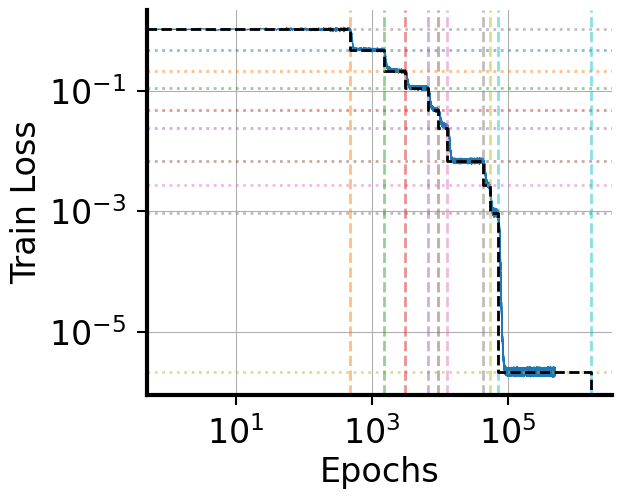

In [846]:
# Plot loss vs. epochs
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(loss_history, label='Online Gradient Descent', linewidth=1)
color_map = plt.get_cmap(name='tab10')

# Labels and title
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Train Loss", fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')

# Get Theory
K = min(d, H, c)
_, losses, taus = limiting_conjecture(Sigma_xx, Sigma_yx, K)

# Loss levels (horizontal lines)
for i, loss in enumerate(losses):
    color = "grey" if i == 0 else color_map(i - 1)
    ax.axhline(y=loss * 2 / c, color=color, alpha=0.5, linestyle='dotted', linewidth=2)

# Jump times (vertical lines)
const = -np.log(np.sqrt(2) * init_scale) / (2 * learning_rate)
for i, tau in enumerate(taus):
    ax.axvline(x=tau * const, color=color_map(i), alpha=0.5, linestyle='dashed', linewidth=2)

# Levels and Jumps (step line)
maxepoch = max(taus[-1] * const, num_epochs)
t_steps = [tau * const for tau in taus] + [maxepoch]
l_steps = [loss * 2 / c for loss in losses] + [losses[-1] * 2 / c]
ax.step(t_steps, l_steps, where='post', color='k', linestyle='--', lw=2, label='AGF Theory')

# Style the axes
style_axes(ax)

# ax.legend(fontsize=20)
plt.savefig("loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

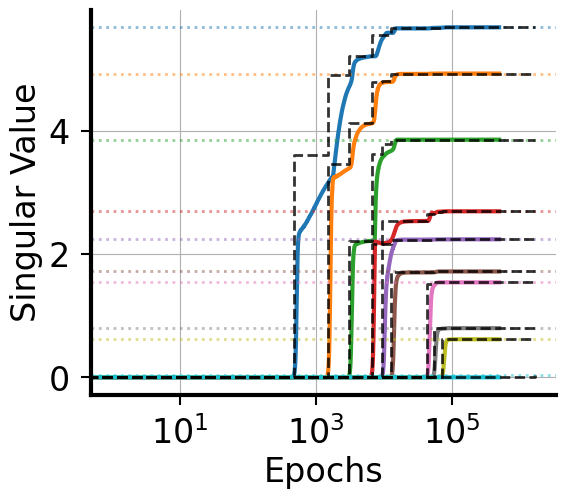

In [847]:
# Plot loss vs. epochs
fig, ax = plt.subplots(figsize=(6, 5))
color_map = plt.get_cmap(name='tab10')

singular_values = np.array(svalue_history)
for i in range(singular_values.shape[1]):
    ax.plot(singular_values[:,i], label='Singular Value {}'.format(i), linewidth=3)

# Labels and title
ax.set_xlabel("Epochs", fontsize=24)
ax.set_ylabel("Singular Value", fontsize=24)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(1e-6, loss_history[0] * 2)

# Get Theory
K = min(d, H, c)
betas, _, taus = limiting_conjecture(Sigma_xx, Sigma_yx, K)

# Get Jump times
const = -np.log(np.sqrt(2) * init_scale) / (2 * learning_rate)
maxepoch = max(taus[-1] * const, num_epochs)
t_steps = [tau * const for tau in taus] + [maxepoch]

# Get Singular values of betas
singular_values_theory = np.zeros((K, K+1))
for i in range(K+1):  # For each step
    svals = np.linalg.svd(betas[i], compute_uv=False)
    singular_values_theory[:num, i] = svals[:K]

# Plot times x singular values (step lines)
for k in range(num):
    s_steps = list(singular_values_theory[k, :num+1]) + [singular_values_theory[k, num]]
    ax.step(t_steps, s_steps, where='post', linestyle='--', lw=2, color='k', zorder=10, alpha=0.8)

# Plot final singular values (horizontal lines)
for i, sval in enumerate(singular_values_theory[:,K]):
    ax.axhline(y=sval, color=color_map(i), alpha=0.5, linestyle='dotted', linewidth=2)

# Style the axes
style_axes(ax)

# ax.legend(fontsize=20)
plt.savefig("singular-values.pdf", format="pdf", bbox_inches="tight")
plt.show()